In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import pymc as pm
import arviz as az

%load_ext lab_black

# 9. Weibull Lifetimes*

Adapted from [Unit 5: metro2.m](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit5/metro2.m).

## Set up equations

In [2]:
def f(α, η, t):
    """
    Weibull likelihood, t can be an array or float.
    """
    return np.prod(α * η * t ** (α - 1) * np.exp(-η * t ** (α)))


def π(α, η, β, ξ):
    """
    Combined prior: exponential w/rate of 1 on α and gamma on η.
    """
    return np.exp(-α) * η ** (β - 1) * np.exp(-ξ * η)


def q(α, η, α_prop, η_prop):
    """
    Proposal, product of two exponentials with means of α and η.
    """
    return 1 / (α * η) * np.exp(-α_prop / α - η_prop / η)

## Run the model

  0%|          | 0/50000 [00:00<?, ?it/s]

acceptance rate: 0.199
np.mean(α_samples_burned)=0.888
np.var(α_samples_burned)=0.137
np.mean(η_samples_burned)=1.836
np.var(η_samples_burned)=0.749


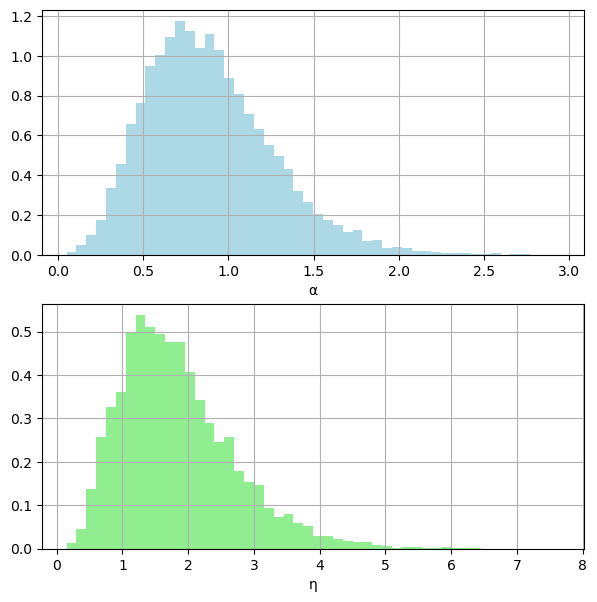

In [3]:
seed = 235
rng = np.random.default_rng(seed)
obs = 50000
burn = 500
accepted = np.zeros(obs)

# observed data (time in seconds)
t = np.array([0.2, 0.1, 0.25])

# hyperparameters
# these will not change
β = 2
ξ = 2

# initial values
# these are just the starting points, they will change throughout
α = 2
η = 2

# create sample vectors with length obs
α_samples = np.zeros(obs)
η_samples = np.zeros(obs)

# pre-generate 3 sets of uniform randoms
unif = rng.uniform(size=obs)
log_unif_α = np.log(rng.uniform(size=obs))
log_unif_η = np.log(rng.uniform(size=obs))

for i in tqdm(range(obs)):
    # proposals
    # by inverse transform sampling
    α_prop = -α * log_unif_α[i]
    η_prop = -η * log_unif_η[i]

    # acceptance ratio
    ar = (f(α_prop, η_prop, t) * π(α_prop, η_prop, β, ξ) * q(α_prop, η_prop, α, η)) / (
        f(α, η, t) * π(α, η, β, ξ) * q(α, η, α_prop, η_prop)
    )

    ρ = min(ar, 1)

    if unif[i] < ρ:
        α = α_prop
        η = η_prop
        accepted[i] = 1

    α_samples[i] = α
    η_samples[i] = η

print(f"acceptance rate: {accepted.sum()/obs:.3f}")

# burning some samples (set in burn var above)
α_samples_burned = α_samples[burn:]
η_samples_burned = η_samples[burn:]

print(f"{np.mean(α_samples_burned)=:.3f}")
print(f"{np.var(α_samples_burned)=:.3f}")
print(f"{np.mean(η_samples_burned)=:.3f}")
print(f"{np.var(η_samples_burned)=:.3f}")

# posterior densities
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))

ax1.grid(True)
ax1.hist(α_samples, color="lightblue", density=True, bins=50)
ax1.set_xlabel("α")

ax2.grid(True)
ax2.hist(η_samples, color="lightgreen", density=True, bins=50)
ax2.set_xlabel("η")

plt.show()

## Trace plots

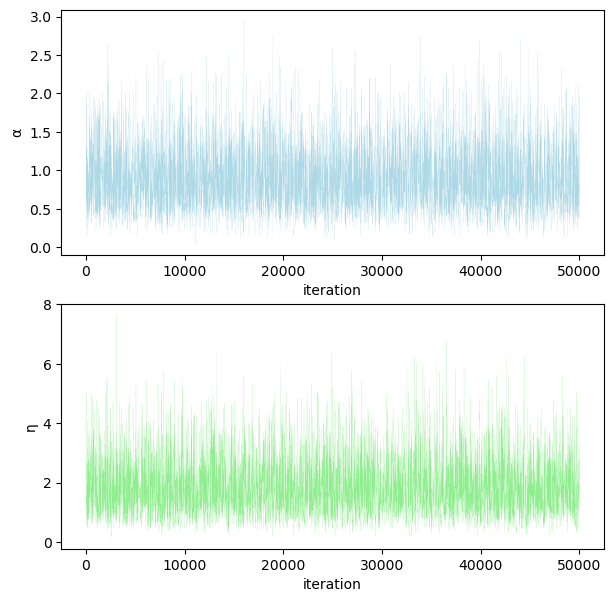

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))

ax1.plot(range(obs), α_samples, color="lightblue", linewidth=0.1)
ax1.set_ylabel("α")
ax1.set_xlabel("iteration")

ax2.plot(range(obs), η_samples, color="lightgreen", linewidth=0.1)
ax2.set_ylabel("η")
ax2.set_xlabel("iteration")

plt.show()

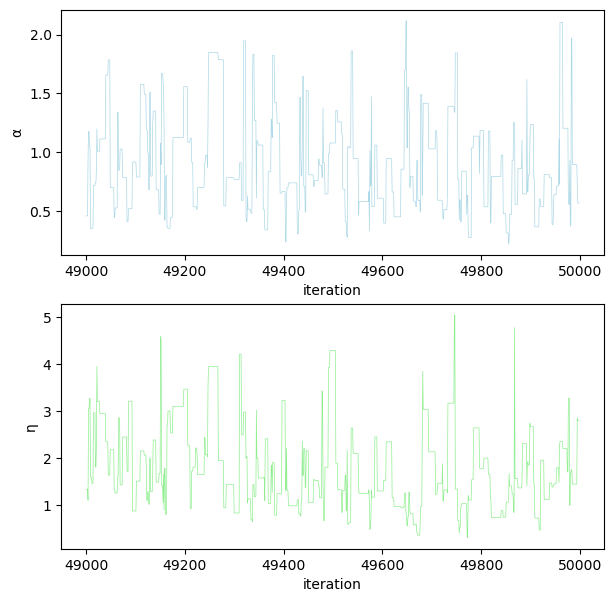

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))

ax1.plot(range(49000, 50000), α_samples[-1000:], color="lightblue", linewidth=0.5)
ax1.set_ylabel("α")
ax1.set_xlabel("iteration")

ax2.plot(range(49000, 50000), η_samples[-1000:], color="lightgreen", linewidth=0.5)
ax2.set_ylabel("η")
ax2.set_xlabel("iteration")

plt.show()

## Inverse transform sampling

Students always wonder why the proposals are coded the way they are here. Those of you who took Simulation might remember [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling
):

If $X$ is a continuous random variable with cdf $F_X$, then $Y=F_X(X)$ has a uniform distribution on [0, 1]. And the inverse: if $Y$ is uniform on [0, 1] and $X$ has cdf $F_X$, then $F^{-1}_{X}(Y)$ has the same distribution as $X$.

You can use this to transform uniform random numbers to whatever continuous distribution you want. You just need to find the inverse of whatever distribution you're generating from.

The CDF of the Exponential distribution:

$F_X(X) = Y = 1 - e^{-\lambda X}$

Find the inverse:

$$
\begin{align*}
Y & = 1 - e^{-\lambda X} \\
Y - 1 & = - e^{-\lambda X} \\
1 - Y & = e^{-\lambda X} \\
\log(1 - Y) & = -\lambda X \\
 X & = \frac{\log(1 - Y)}{-\lambda} \\
X & = \frac{1}{-\lambda}\log(1 - Y) \\
\end{align*}
$$

Remember that we've set $\eta = 1/\lambda$ and $\alpha = 1/\lambda$ for their respective exponentials.

Also, $1 - Y$ and $Y$ will be equivalent. So we end up with the following lines in the code:

```python
log_unif_α = np.log(rng.uniform(size=obs))
log_unif_η = np.log(rng.uniform(size=obs))

for i in tqdm(range(obs)):
    # proposals
    # by inverse transform sampling
    α_prop = -α * log_unif_α[i]
    η_prop = -η * log_unif_η[i]

```

This would work too in NumPy:

```python
α_prop = rng.random.exponential(α)
η_prop = rng.random.exponential(η)
```

## Double-check with PyMC

We can start looking at how this might work in PyMC, even though we won't be using this in assignments until Unit 6.

In [6]:
with pm.Model():
    alpha = pm.Exponential("alpha", lam=1)
    eta = pm.Gamma("eta", 2, 2)

    # convert to pymc parameter for weibull
    beta = pm.Deterministic("beta", eta ** (-1 / alpha))

    pm.Weibull("likelihood", alpha, beta, observed=t)

    trace = pm.sample(3000)

az.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, eta]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.889,0.367,0.277,1.583,0.004,0.003,8017.0,6913.0,1.0
eta,1.835,0.870,0.440,3.463,0.011,0.008,6774.0,6695.0,1.0
beta,1.134,17.391,0.011,1.612,0.159,0.113,9032.0,7213.0,1.0


In [7]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Sat Aug 05 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.9.0

numpy     : 1.24.2
pymc      : 5.3.0
matplotlib: 3.6.3
arviz     : 0.15.1

